In this Jupyter Notebook, we will study the US unemployment rate between 1996 and 2006.  We will use a Python ARIMA model to generate a predictor and plot our predictor vs the actual time series.  This Notebook is part of the analysis of the effects of on-stationarity in time series and should NOT be used in production as it is used for illustrative purposes only.

The process we will follow:
1. Load and filter our data
2. Use the Augmented Dickey-Fuller test to calculate the number of times we need to differenciate (if any) to eliminate trends in our data.
3. We will iteratively test SARIMAX models from statsmodels to finde the parameters of our ARMA model.  We will try to minimize AIC/BIC to find the best values
4. With the parameters found in 2 and 3, we will fit our time series and predict values for the last 20 months of the series.
5. We will plot the predictions vs the actual time series

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

First things first, we load our data and filter the period that we will study in this notebook.

The US unemployment data was downloaded from https://fred.stlouisfed.org/.  

In [3]:
# Load Unemployment rate
uen = pd.read_csv('UNRATE.csv', parse_dates=True, index_col='DATE')
uen = uen['1996-01-01':'2006-12-31'].dropna()

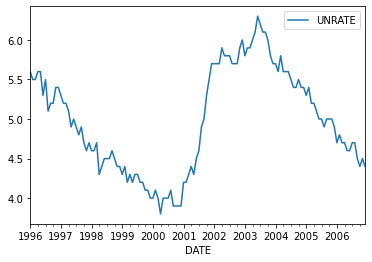

In [4]:
uen.plot()
plt.show()

We get the number of differencing needed using the Augmented Dickey-Fuller test. 

In [5]:
# Import adfuller from statsmodels
from statsmodels.tsa.stattools import adfuller

In [6]:
# Get the differencing
adf = adfuller(uen.iloc[:, 0])
print('ADF Statistic:', adf[0])
print('p-value:', adf[1])

# First differencing
adf = adfuller(uen.diff().dropna().iloc[:,0])
print('1st differencing ADF Statistic:', adf[0])
print('1st differencing p-value:', adf[1])

# Second differencing
adf = adfuller(uen.diff().diff().dropna().iloc[:,0])
print('2nd differencing ADF Statistic:', adf[0])
print('2nd differencing p-value:', adf[1])

# Third differencing
adf = adfuller(uen.diff().diff().diff().dropna().iloc[:,0])
print('3rd differencing ADF Statistic:', adf[0])
print('3rd differencing p-value:', adf[1])

print('...')

# 12th differencing
adf = adfuller(uen.diff().diff().diff().diff().diff().diff().diff().diff().diff().diff().diff().diff().dropna().iloc[:,0])
print('12th differencing ADF Statistic:', adf[0])
print('12th differencing p-value:', adf[1])

ADF Statistic: -1.4389625208264603
p-value: 0.5634611210039485
1st differencing ADF Statistic: -4.959648055838395
1st differencing p-value: 2.6657340992906748e-05
2nd differencing ADF Statistic: -6.937215005690739
2nd differencing p-value: 1.047139688267331e-09
3rd differencing ADF Statistic: -6.695043007645027
3rd differencing p-value: 4.019426718481913e-09
...
12th differencing ADF Statistic: -13.515338258459085
12th differencing p-value: 2.80150477414719e-25


We can already see that we can't eliminate the trend on this time series, even after differencing 12 times, as there is not any single one.

Our smallest p-value is obtained after one differencing, so we will proceed to a single differencing for the next steps of this Notebook.

The next step, we get the best ARMA parameters with AIC/BIC.

So, we loop AIC / BIC models, trying to find the one that minimizes both.

In [7]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [14]:
# Initialize list
order_aic_bic = []
# Loop over p values from 0-3
for p in range(4):
    # Loop over q values from 0-3
    for q in range(4):
        try:
            # create and fit ARMA(p,q) model
            model = SARIMAX(uen, order=(p, 1, q))
            results = model.fit()
            # Append order and results tuple
            order_aic_bic.append((p, q, results.aic, results.bic))
        except:
            order_aic_bic.append((p, q, None, None))

Once we have the list with different combinations of AIC/BIC, we print in ascending order to get the ideal values for our model.

In [9]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic,
                        columns=['p', 'q', 'AIC', 'BIC'])
# Print order_df in order of increasing AIC and BIC and choose the minimum
print(order_df.sort_values('AIC'))
print(order_df.sort_values('BIC'))

    p  q         AIC         BIC
9   2  1 -170.776369 -159.275579
6   1  2 -170.102506 -158.601717
7   1  3 -168.968978 -154.592992
13  3  1 -168.800186 -154.424200
10  2  2 -168.792063 -154.416076
12  3  0 -168.647719 -157.146930
2   0  2 -168.247003 -159.621411
14  3  2 -167.408547 -150.157363
3   0  3 -167.386270 -155.885481
11  2  3 -166.985547 -149.734363
8   2  0 -166.142011 -157.516419
15  3  3 -166.125416 -145.999035
4   1  0 -164.228557 -158.478162
0   0  0 -164.004777 -161.129579
1   0  1 -163.606414 -157.856020
5   1  1 -163.298206 -154.672614
    p  q         AIC         BIC
0   0  0 -164.004777 -161.129579
2   0  2 -168.247003 -159.621411
9   2  1 -170.776369 -159.275579
6   1  2 -170.102506 -158.601717
4   1  0 -164.228557 -158.478162
1   0  1 -163.606414 -157.856020
8   2  0 -166.142011 -157.516419
12  3  0 -168.647719 -157.146930
3   0  3 -167.386270 -155.885481
5   1  1 -163.298206 -154.672614
7   1  3 -168.968978 -154.592992
13  3  1 -168.800186 -154.424200
10  2  2 -

Both AIC and BIC give us  different parameters for our model.  As we are looking for a predictive model, theory dictates that we should give preference to the AIC-minimizing parameters. 

Then, we input the calculated values and get our model.

In [15]:
model = SARIMAX(uen, order=(2, 1, 1))
results = model.fit()

In [11]:
# Make in-sample prediction
forecast = results.get_prediction(start=-20, dynamic=True)

Great! Now that we have the forecast, we print its mean and the confidence interval vs. the actual series to illustrate the accuracy of our model.

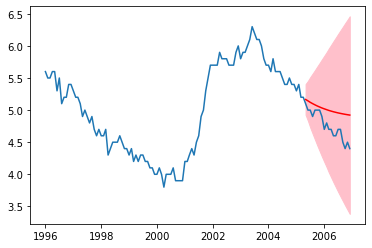

In [12]:
# Plot prediction
plt.plot(uen.index, uen.values)
plt.plot(forecast.predicted_mean.index,
         forecast.predicted_mean.values,
         color='red',
         label='forecast')
# Shade confidence interval
test = forecast.conf_int()
lower_limits = test.iloc[:, 0]
upper_limits = test.iloc[:, 1]
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

plt.show() 

Our predictor is not good!